<a href="https://colab.research.google.com/github/mchong6/JoJoGAN/blob/main/stylize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JoJoGAN: One Shot Face Stylization

In [1]:
#@title Setup. This will take a few minutes.
# !git clone https://github.com/mchong6/JoJoGAN.git
# %cd JoJoGAN
# !pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
# !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
# !sudo unzip ninja-linux.zip -d /usr/local/bin/
# !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

# %load_ext autoreload
# %autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import lpips
import wandb
from model import *
from e4e_projection import projection as e4e_projection

# from google.colab import files
from copy import deepcopy
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)



In [2]:
#@title Download models
#@markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = True #@param {type:"boolean"}    
device = 'cuda' #@param ['cuda', 'cpu']

# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "supergirl.pt": "1L0y9IYgzLNzB-33xTpXpecsKU-t9DpVC",
    "supergirl_preserve_color.pt": "1VmKGuvThWHym7YuayXxjv0fSn32lfDpE",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(False)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)
from copy import deepcopy

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


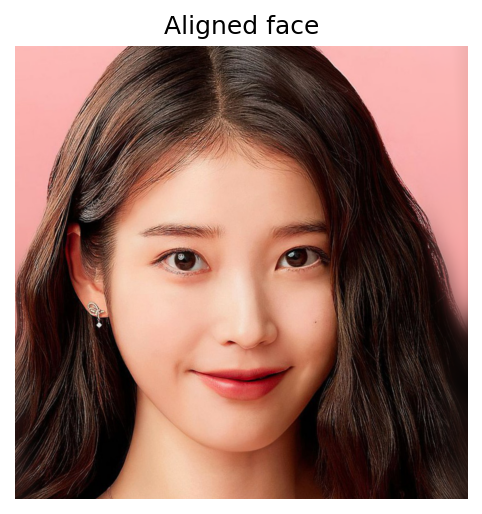

In [3]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
filename = 'iu.jpeg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

In [4]:
my_face = align_face('style_images_aligned/증명사진.jpg')

RuntimeError: Unable to open file: style_images_aligned/증명사진.jpg

In [ ]:
from PIL import Image

my_face_w = e4e_projection(my_face, name, device).unsqueeze(0)

In [ ]:
!nvidia-smi

# Use pretrained styles

In [5]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'arcane_multi' #@param ['art', 'arcane_multi', 'supergirl', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_face_w, input_is_latent=True)
    my_sample = generator(my_face_w, input_is_latent=True)

# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(my_face).unsqueeze(0).to(device)

def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))


# my_output = torch.cat([style_image, face, my_sample], 0)
# display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

# output = torch.cat([original_sample, sample], 0)
# display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')
norm_range(my_sample, (-1,1))
Image.fromarray(np.array(style_image.to('cpu')[0].permute(1,2,0)*255, np.uint8))

NameError: name 'my_face_w' is not defined

In [24]:
style_image.to('cpu')

tensor([[[[-0.6471, -0.6471, -0.6471,  ..., -0.9608, -0.9529, -0.9529],
          [-0.6471, -0.6471, -0.6471,  ..., -0.9608, -0.9529, -0.9529],
          [-0.6549, -0.6549, -0.6549,  ..., -0.9608, -0.9529, -0.9529],
          ...,
          [ 0.1059,  0.1059,  0.1137,  ..., -0.0588, -0.0588, -0.0588],
          [ 0.0980,  0.1059,  0.1137,  ..., -0.0667, -0.0667, -0.0667],
          [ 0.0980,  0.1059,  0.1137,  ..., -0.0745, -0.0745, -0.0745]],

         [[-0.7647, -0.7647, -0.7647,  ..., -0.9608, -0.9529, -0.9529],
          [-0.7647, -0.7647, -0.7647,  ..., -0.9608, -0.9529, -0.9529],
          [-0.7725, -0.7725, -0.7725,  ..., -0.9608, -0.9529, -0.9529],
          ...,
          [-0.3255, -0.3255, -0.3176,  ..., -0.4588, -0.4510, -0.4510],
          [-0.3255, -0.3255, -0.3255,  ..., -0.4588, -0.4588, -0.4588],
          [-0.3255, -0.3255, -0.3255,  ..., -0.4588, -0.4588, -0.4588]],

         [[-0.8196, -0.8196, -0.8196,  ..., -0.9608, -0.9529, -0.9529],
          [-0.8196, -0.8196, -

# Train with your own style images

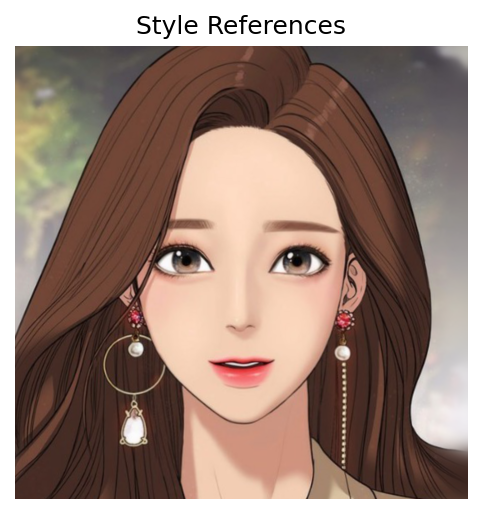

In [42]:
#@markdown Upload your own style images into the style_images folder and type it into the field in the following format without the directory name. Upload multiple style images to do multi-shot image translation
# names = ['arcane_caitlyn.jpeg', 'arcane_jinx.jpeg', 'arcane_jayce.jpeg', 'arcane_viktor.jpeg'] #@param {type:"raw"}
names = ['godess.jpg']
targets = []
latents = []

for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='Style References')

In [43]:
#@title Finetune StyleGAN
#@markdown alpha controls the strength of the style
alpha =  1.0 #@param {type:"slider", min:0, max:1, step:0.1}
alpha = 1-alpha

#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
preserve_color = True #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 200 #@param {type:"number"}
#@markdown Log training on wandb and interval for image logging
use_wandb = True #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    config.preserve_color = preserve_color
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)

lpips_fn = lpips.LPIPS(net='vgg').to(device)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [7,9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    if preserve_color:
        random_alpha = 0
    else:
        random_alpha = np.random.uniform(alpha, 1)
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)
    loss = lpips_fn(F.interpolate(img, size=(256,256), mode='area'), F.interpolate(targets, size=(256,256), mode='area')).mean()
    
    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, range=(-1, 1)))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂
loss,0.19492


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/anaconda3/envs/3dgan/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


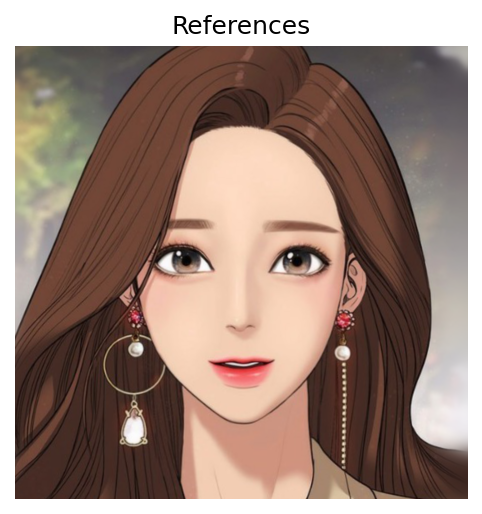

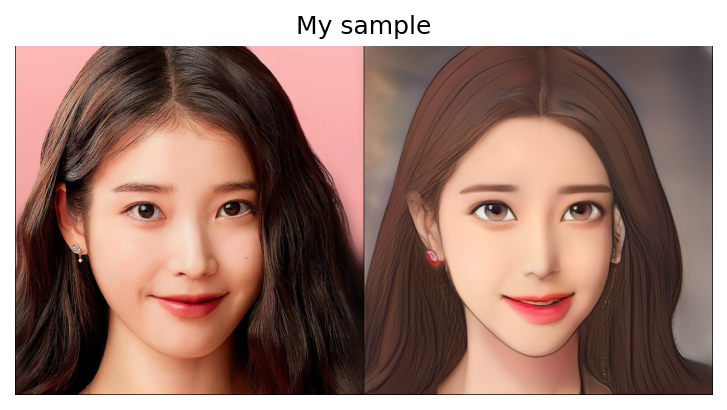

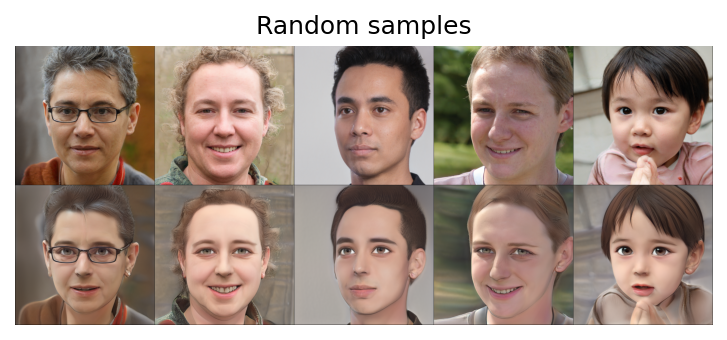

In [44]:
# @title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)
# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)
    
face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')

In [77]:
from enum import Enum

class FaceOption(Enum):
    arcane_caitlyn = 0
    arcane_jinx = 1
    arcane_multi = 2 
    jojo_yasuho = 3
    supergirl = 4
    
    
    def __str__(self):
        return f"{self.name}"
    @property
    def get_model(self):
        return os.path.join('models', f"{self.name}")
    @property
    def get_img(self):
        return os.path.join('style_images_alined', f"{self.name}.pt")

    @classmethod
    def has_value(cls, value):
        return value in cls._member_names_   
# FaceOption.arcane_jinx.get_model
# for item in FaceOption.keys():
#     print(item)
# for item in FaceOption.__members__:
#     print(FaceOption[item], item)

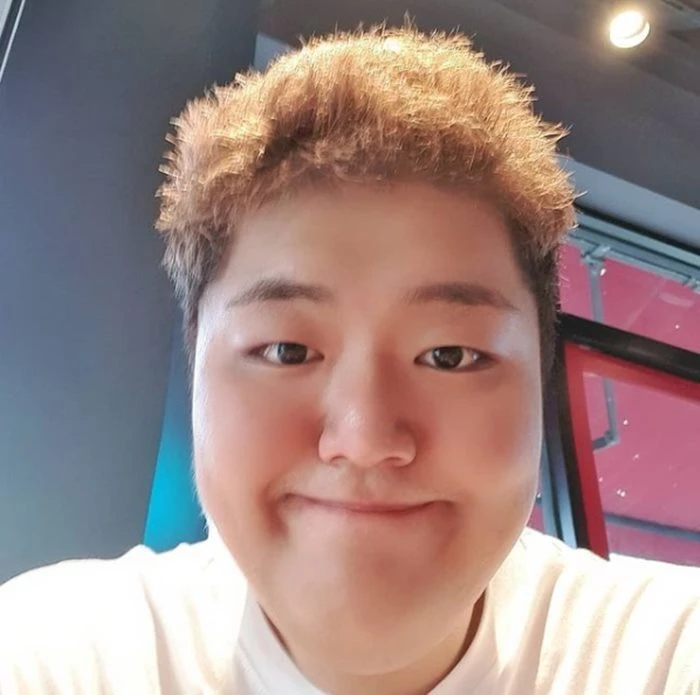

In [2]:
# strip_path_extension(filepath)
# filepath
# aligned_face
from PIL import Image
Image.open('save/공혁준.webp')
# from PIL import features
# print (features.check_module('webp'))